In [1]:
from Bio import AlignIO, Seq
import os
# family_set = {}
# for prot_fam in os.listdir("data/hamap_alignments/"):
#     family_ids = [seq.id.split("_")[0] for seq in AlignIO.read(f"data/hamap_alignments/{prot_fam}", "fasta")]
#     family_set[prot_fam] = family_ids
hamap_families = []
hamap_sequences = []
for prot_fam in os.listdir("data/hamap_alignments/"):
    family_seq = list(AlignIO.read(f"data/hamap_alignments/{prot_fam}", "fasta"))
    hamap_sequences.extend(family_seq)
    hamap_families.extend([prot_fam]*len(family_seq))

In [2]:
for i in range(len(hamap_sequences)):
    hamap_sequences[i].seq = Seq.Seq(str(hamap_sequences[i].seq).replace('.', '').replace('-', ''))

In [3]:
from Bio import SeqIO
with open("data/hamap_all.fasta", "w") as f:
    SeqIO.write(hamap_sequences, f, 'fasta')

In [4]:
import pandas as pd
train_hits = pd.read_csv('data/train_hamap_hits.tsv', sep='\t')
train_hits

,P32234,R7DPV1_9FIRM,100.5
0,P32234,A0A412FP31_9FIRM,91.7
1,P32234,A0A1T4Q626_9FIRM,91.3
2,P32234,A0A1T4N747_9ENTE,90.5
3,P32234,R6U7Y4_9FIRM,90.5
4,P32234,A0A417CIT7_9FIRM,90.1
...,...,...,...
544574,Q6UY62,Z_BCNVU,90.9
544575,Q6UY62,Z_TAMVU,90.1
544576,Q6UY62,Z_PARVP,87.8
544577,Q6UY62,Z_PIRVV,85.5


In [5]:
import torch
import numpy as np
f_ind = {f:i for i, f in enumerate(set(hamap_families))}
fam_centers = np.random.normal(0, 3, (len(f_ind), 128))
hamap_cluster_labels = [f_ind[f] for f in hamap_families]
hamap_emb = np.random.normal(0, 1, (len(hamap_sequences), 128)) + fam_centers[hamap_cluster_labels, :]
print(hamap_emb.shape)

(5447680, 128)


In [6]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=len(f_ind), batch_size=16)
hamap_cluster_pred = kmeans.fit(hamap_emb)

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
from sklearn.metrics import v_measure_score
vscore = v_measure_score(hamap_cluster_labels, hamap_cluster_pred.labels_)
print(vscore)

0.9400638745238452


In [8]:
from collections import Counter
counts = Counter(hamap_cluster_labels)
print(counts)

Counter({1133: 19194, 972: 15783, 1363: 15566, 340: 14102, 513: 13477, 1146: 13292, 1223: 13228, 2224: 12965, 1747: 12749, 1357: 12398, 1269: 12240, 1929: 12210, 2270: 12130, 1773: 12098, 553: 12078, 22: 12073, 760: 11889, 262: 11867, 2160: 11833, 2031: 11802, 1715: 11647, 240: 11340, 2077: 11275, 1637: 11262, 525: 11257, 1648: 11213, 41: 11188, 1817: 11170, 126: 11170, 309: 11147, 1849: 11042, 858: 11020, 2338: 11014, 2317: 11002, 1095: 10966, 1600: 10954, 423: 10943, 242: 10891, 1527: 10849, 1901: 10801, 574: 10797, 1087: 10689, 990: 10629, 1806: 10612, 1503: 10582, 1956: 10525, 1043: 10516, 1745: 10515, 1597: 10433, 1119: 10427, 110: 10411, 1992: 10401, 800: 10377, 2356: 10368, 2131: 10362, 1035: 10336, 1791: 10270, 657: 10257, 73: 10247, 190: 10233, 205: 10230, 1707: 10223, 1924: 10216, 617: 10215, 1000: 10212, 1622: 10210, 2178: 10202, 1967: 10153, 808: 10139, 1836: 10138, 1227: 10134, 207: 10094, 1115: 10079, 2036: 10078, 232: 10068, 1596: 10059, 571: 10021, 715: 10011, 1225: 999

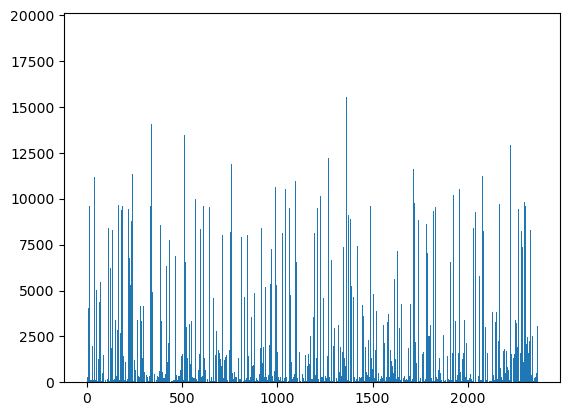

In [9]:
import matplotlib.pyplot as plt
plt.hist(hamap_cluster_labels, bins=np.arange(len(f_ind)))
plt.show()

In [11]:
import os
from Bio import AlignIO

hamap_families = []
hamap_sequences = []
for i, prot_fam in enumerate(os.listdir("data/hamap_alignments/")):
    family_seq = list(AlignIO.read(f"data/hamap_alignments/{prot_fam}", "fasta"))[:100]
    hamap_sequences.extend(family_seq)
    hamap_families.extend([prot_fam]*len(family_seq))
    if(i > 100):
        break

import pickle
with open("emb/base_hamap_small_emb.pkl", "rb") as f:
    base_emb = pickle.load(f)
with open("emb/finetune_hamap_small_emb.pkl", "rb") as f:
    ft_emb = pickle.load(f)

In [31]:
import torch
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import v_measure_score

f_ind = {f:i for i, f in enumerate(set(hamap_families))}
hamap_cluster_labels = [f_ind[f] for f in hamap_families]

def eval_emb(cluster_labels, embeddings):
    kmeans = MiniBatchKMeans(n_clusters=max(cluster_labels)+1, batch_size=16, n_init='auto')
    cluster_pred = kmeans.fit(embeddings)
    vscore = v_measure_score(cluster_labels, cluster_pred.labels_)
    return vscore, cluster_pred





In [33]:
base_scores = np.array([eval_emb(hamap_cluster_labels, base_emb['embeddings'])[0] for _ in range(100)])
ft_scores = np.array([eval_emb(hamap_cluster_labels, ft_emb['embedding'])[0] for _ in range(100)])
# vscore, cluster_pred = eval_emb(hamap_cluster_labels, base_emb['embeddings'])
# vscore, cluster_pred = eval_emb(hamap_cluster_labels, ft_emb['embedding'])

In [13]:
from sklearn.manifold import TSNE
base_ld = TSNE().fit_transform(base_emb['embeddings'])
ft_ld = TSNE().fit_transform(ft_emb['embedding'])

In [42]:
import seaborn as sns
from matplotlib import colormaps
cm = colormaps['tab20c']

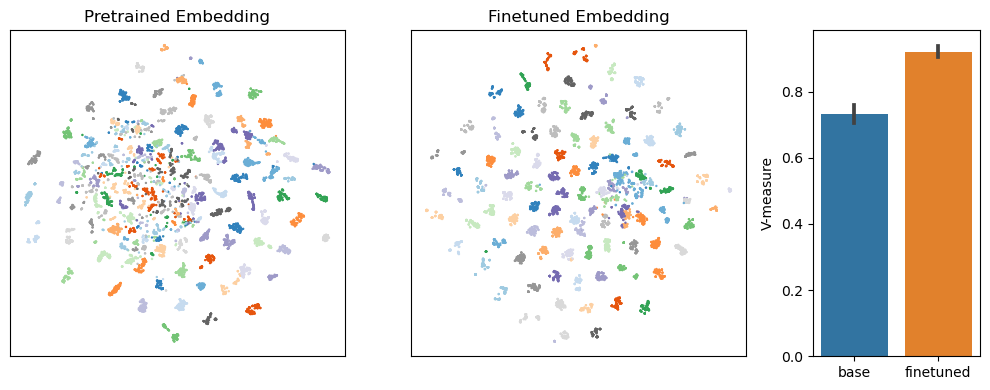

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 2, 1]})
axes[0].scatter(base_ld[:, 0], base_ld[:, 1], s=0.5, c=cm(np.array(hamap_cluster_labels) % 20))
axes[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axes[0].set_title("Pretrained Embedding")
axes[1].scatter(ft_ld[:, 0], ft_ld[:, 1], s=0.5, c=cm(np.array(hamap_cluster_labels) % 20))
axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axes[1].set_title("Finetuned Embedding")
sns.barplot([base_scores, ft_scores], errorbar="sd", ax=axes[2])
axes[2].set_ylabel("V-measure")
axes[2].set_xticklabels(["base", "finetuned"])
fig.tight_layout()

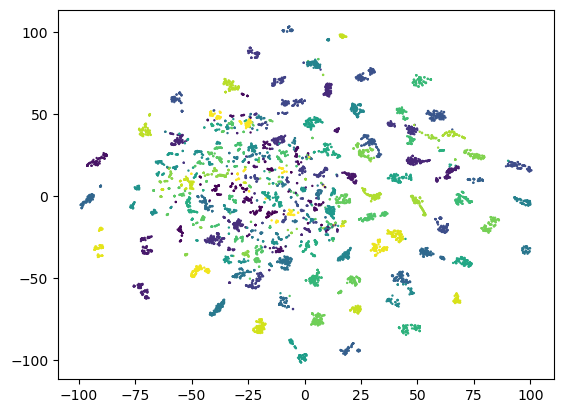

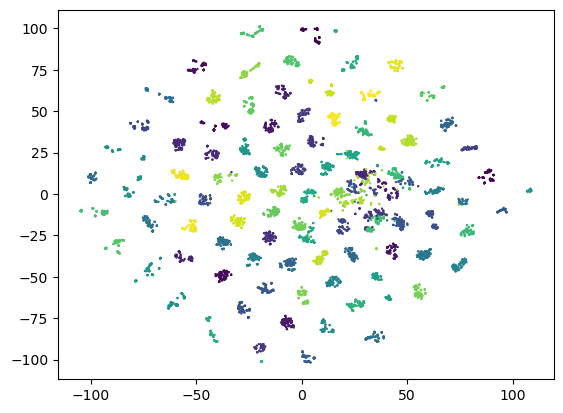

In [12]:
import matplotlib.pyplot as plt
plt.scatter(base_ld[:, 0], base_ld[:, 1], s=0.5, c=hamap_cluster_labels)
plt.show()
plt.scatter(ft_ld[:, 0], ft_ld[:, 1], s=0.5, c=hamap_cluster_labels)
plt.show()